# Exercise 1: Process featureCounts output for DESeq2 input file

For your homework you used featureCounts to obtain the number of times a gene is observed in any of the samples. The file however, is a bit bulk and can't be used directly to run DESeq2. There are several ways to process this file, I will show you how I did it:

In [ ]:
%%bash
# move to your directory where featureCounts is located:
tail -n +2 featureCounts.txt | cut -f1,6,7,8,9,10 > featureCounts_trimmed.txt

Now that the file has defined columns I can more to R and start processing the file further

In [2]:
# load in the table
fc.table <- read.table('~/Module_1/tardbp_shrna/featureCounts/featureCounts_trimmed.txt', header = T)

# rename the columns
colnames(fc.table) <- c('Geneid', 'Length', 'NT_shRNA_hepg2_rep1', 'NT_shRNA_hepg2_rep2', 'TARDBP_shRNA_hepg2_rep1', 'TARDBP_shRNA_hepg2_rep2')

# separate out the counts to perform numeric operations
fc.counts <- fc.table[,c(3:6)]

# extract the indices of the rows which have low counts
to.remove <- which(fc.counts[,1] < 5 & fc.counts[,2] < 5 & fc.counts[,3] < 5 & fc.counts[,4] < 5)

# remove the rows from the original table
fc.table.filtered <- fc.table[-to.remove, ]

head(fc.table)
head(fc.table.filtered)
dim(fc.table)
dim(fc.table.filtered)

Geneid,Length,NT_shRNA_hepg2_rep1,NT_shRNA_hepg2_rep2,TARDBP_shRNA_hepg2_rep1,TARDBP_shRNA_hepg2_rep2
ENSG00000223972.5_2,1735,0,0,0,0
ENSG00000227232.5_2,1351,27,42,40,35
ENSG00000243485.5_5,1021,0,0,0,0
ENSG00000237613.2_2,1219,0,0,0,0
ENSG00000268020.3_4,840,0,0,0,0
ENSG00000240361.2_3,1414,0,0,0,0


,Geneid,Length,NT_shRNA_hepg2_rep1,NT_shRNA_hepg2_rep2,TARDBP_shRNA_hepg2_rep1,TARDBP_shRNA_hepg2_rep2
2,ENSG00000227232.5_2,1351,27,42,40,35
8,ENSG00000238009.6_6,3726,0,4,4,8
11,ENSG00000237683.5,2661,22,20,16,27
14,ENSG00000239906.1_5,323,6,2,3,7
15,ENSG00000241860.6_5,6195,26,32,35,35
18,ENSG00000228463.4,3954,77,69,63,67


[1] 60880     6

[1] 19021     6

In [3]:
# now save the table
write.csv(fc.table.filtered, file = 'tardbp_counts_with_length.csv', row.names = F)

# Exercise 2: Extract and plot DESeq2 results for chromosome 1

In this section we will try to extract the DESeq2 results for chromosome 1 without re-running featureCoutns. As above, there are different ways of doing this, here is one of them. 

In [ ]:
%%bash

# remove the first few lines using the 'tail' command. Additionally, use the 'pipe' to also extract only the columns of interest

tail -n +6 ~/biom262_2019/Module_1/annotations/hg19/gencode.v29lift37.annotation.gtf | cut -f 1,3,4,9 > gencode_filtered.gtf

# extract only rows containing 'chr1'. (note, the -w flag enforces a direct match. Else we would also get partial matches with chr10, chr11 etc.)
grep -w 'chr1' gencode_filtered.gtf > gencode_chr1.gtf

# since the format of column 9 is different from the other 2 we create two separate files which will individually be easier to process
cut -f 1,2,3 gencode_chr1.gtf > gencode_chr1_pos.gtf
cut -f4 gencode_chr1.gtf > gencode_chr1_info.gtf

# lastly, make sure that your final files look as expected. Comparing the relative number of lines between the original file
# and the chromosome 1 files we see that the new files have about 1/10 as many lines which matches our expectations
wc -l gencode_filtered.gtf
wc -l gencode_chr1.gtf


Although we reduced the amount of data to deal with by quite a bit we still can do better. from the 'gencode_chr1_info.gtf' we only need the gene ID. Here we use Python to quickly parse the file:

In [ ]:
%%python

# read in file and extract the gene ID information
info_file = open('gencode_chr1_info.gtf', 'r')
out_ids = []
for line in info_file:
	row_info = line.split(';')[0].split(' ')[1][1:-1]
	out_ids.append(row_info)

# write all gene IDs to a .csv file which is easy to read into R
outfile = open('gencode_chr1_IDs.csv', 'w')
for i in range(0, len(out_ids)):
	to_write = out_ids[i] + '\n'
	outfile.write(to_write)
	
outfile.close()

The above should run very fast (try running the same oprations in R and you will see why we did it in Python). Now we are ready to start extracting our DESeq2 results for chromosome 1. Since we want to save all our files in the DESeq2 directory make sure you move there first

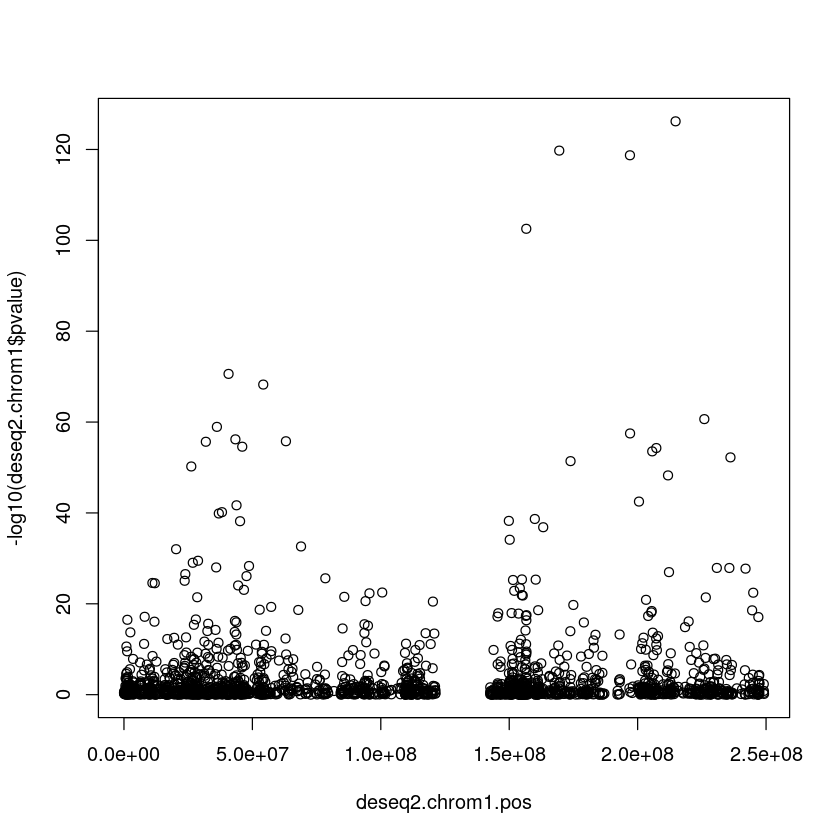

In [4]:
chr1.pos.gtf <- read.delim('~/Module_2/exercises/gencode_chr1_pos.gtf', header = FALSE, stringsAsFactors = FALSE)
chr1.ids <- read.csv('~/Module_2/exercises/gencode_chr1_IDs.csv', header = FALSE, stringsAsFactors = FALSE)
deseq2.results <- read.csv('~/Module_2/notebooks/tardbp_deseq2_results.csv', header = TRUE, row.names = 1)
deseq2.ids <- rownames(deseq2.results)

# combine chromosome 1 info
chr1.info <- cbind(chr1.pos.gtf, chr1.ids)
colnames(chr1.info) <- c('chr', 'feature', 'start_pos', 'gene_id')

# extract genes only
chr1.gene.info <- chr1.info[chr1.info$feature == 'gene',]

# extract all rows from the DEseq2 output which haev a chromosome 1 associated ID
deseq2.chrom1 <- deseq2.results[which(deseq2.ids %in% chr1.gene.info$gene_id),]

# below creates a list ith the ID as name and the position as value
geneID.pos <- as.list(setNames(chr1.gene.info$start_pos, chr1.gene.info$gene_id))

# extract the coordinates for the DESeq2 chromosome 1 results
deseq2.chrom1.pos <- unlist(geneID.pos[rownames(deseq2.chrom1)])

plot(x = deseq2.chrom1.pos, y = -log10(deseq2.chrom1$pvalue))

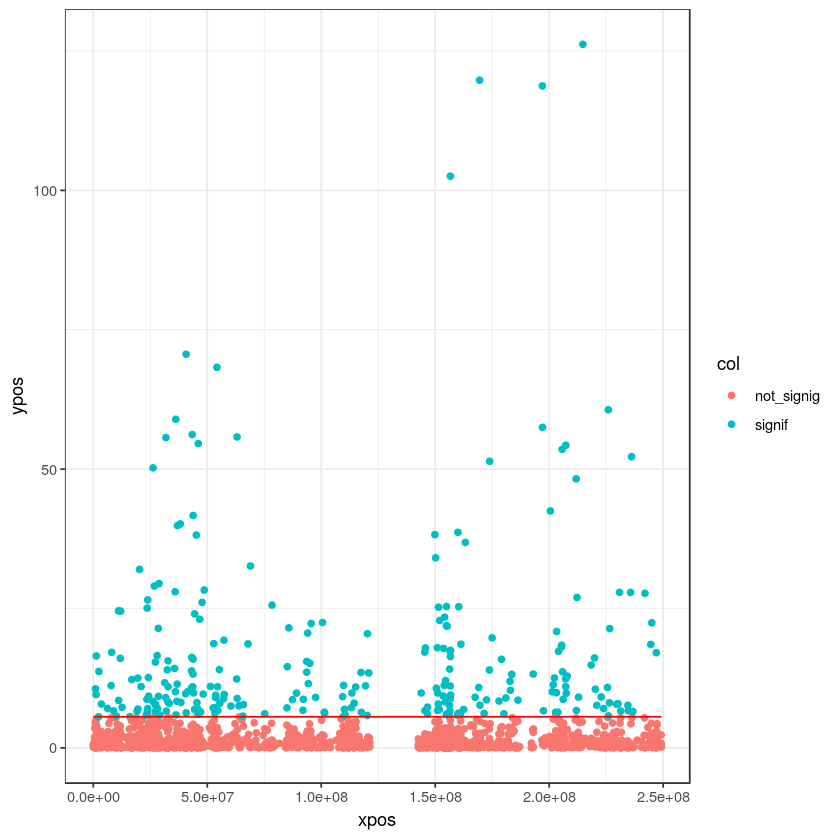

In [6]:
# we can also use ggplot to create plots instead. 
#Generally ggplot is more flexible and has more capabilities than Rs default plotting function
library(ggplot2)

# create Bonferroni corrected p-value threshold:
bonf.thresh <- 0.05 / nrow(deseq2.results)

# we want to add some color. Significant genes get colored red
gene.colors <- rep('not_signig', length(deseq2.chrom1.pos))
gene.colors[deseq2.chrom1$pvalue < bonf.thresh] <- 'signif'

#format the data: ggplot expects a data frame
format.data <- cbind.data.frame(xpos = deseq2.chrom1.pos, ypos = -log10(deseq2.chrom1$pvalue), col = gene.colors)

# and how about making the p-value cutoff visible
p.cutoff <- cbind.data.frame(pos = c(min(format.data$xpos), max(format.data$xpos)),
                            val = c(-log10(bonf.thresh), -log10(bonf.thresh)))

chrom1.plot <- ggplot()+
    geom_point(data = format.data, aes(x = xpos, y = ypos, colour = col)) +
    geom_line(data = p.cutoff, aes(x = pos, y = val), ,colour = 'red') + 
    theme_bw() 

print(chrom1.plot)